# 2030 분류 모델

In [1]:
import pandas as pd
import numpy as np
import re
# 형태소 분류 태그
from konlpy.tag import Okt
import pickle
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold
# 그리드 서치
from sklearn.model_selection import GridSearchCV


# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## 1. 2030데이터와 언론사 수집 데이터 합치기

- Train data
    - 4.7 보궐선거 데이터
- Test data
    - 대선을 위해 수집한 데이터
    
- 제목 2030이 포함된 데이터는 빼기

In [2]:
# 2030 데이터라고 가정한 데이터
data2030_1 = pd.read_csv('data/data_2030_1.csv', index_col=0)
data2030_2 = pd.read_csv('data/data_2030_2.csv')

# 2030 아닌 데이터
data_1 = pd.read_csv('data/재보궐선거댓글데이터_최종_유튜브수정_0429.csv')
data_2 = pd.read_csv('data/data_candidates.csv')

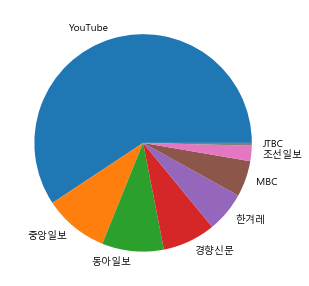

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

plt.pie(data_2['Source'].value_counts(),labels=data_2['Source'].value_counts().index)
plt.show()

In [4]:
data2030_1.shape, data2030_2.shape

((56829, 9), (1173, 9))

In [5]:
data_1.shape, data_2.shape

((144139, 11), (158534, 7))

In [6]:
# 2030 데이터
df1 = pd.concat([ data2030_1['Comment'], data2030_2['Comment'] ] )

# null값 확인
print('null: ', df1.isna().sum())

df1.reset_index(drop=True, inplace=True)
df1

null:  0


0                내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.
1        2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...
2        전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...
3        몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...
4                                         네 죄송합니다. 삭제하겠습니다
                               ...                        
57997    Uh 검언 개혁없이 참  해방은 요원하다,  민주당의  희망 이재명,,, 매국노 이...
57998    최근에보면 페미페미 제목을 붙이는데 시선끌기지 진짜 본질은 그게 아니잖아 개혁을 못...
57999                                   민주당힘내세요 👏👏👏👏👏👏🙆‍♂️
58000                문통령 *다음 차기🇰🇷대통령은 반드시🇰🇷이재명🌟당선되어야😡한다!!!
58001    2030의 남성표심저격이아닌 2030 여성의 표심이겟죠....하...여기도 갑갑하네...
Name: Comment, Length: 58002, dtype: object

In [7]:
# 언론사 데이터 제목에서 2030 포함된 데이터는 삭제
data_1.drop( index=data_1[data_1['제목'].str.contains('2030')].index  ,inplace=True )
data_2.drop( index=data_2[data_2['Title'].str.contains('2030')].index ,inplace=True)

In [8]:
# 2030이 아닌 데이터
df2 = pd.concat( [ data_1['댓글'], data_2['Comment'] ])

# null값 확인
df2.isna().sum()

df2.reset_index(drop=True, inplace=True)
df2

0                           철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~
1         박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...
2                             빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다
3         서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...
4         부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...
                                ...                        
302427    황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...
302428                                    윤석열 .힘내시고.화이팅입니다.
302429                                         황교안 대표 가 보수다
302430    황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...
302431               황교안등 모두 나라위해 힘을 모으는게 맞지요.같은진영 헐뜯지 맙시다.
Length: 302432, dtype: object

In [9]:
# 최종 데이터 합치기
total_df = pd.concat([ df1, df2] , axis=0 )
total_df.reset_index(drop=True, inplace=True)
total_df

0                 내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.
1         2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...
2         전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...
3         몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...
4                                          네 죄송합니다. 삭제하겠습니다
                                ...                        
360429    황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...
360430                                    윤석열 .힘내시고.화이팅입니다.
360431                                         황교안 대표 가 보수다
360432    황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...
360433               황교안등 모두 나라위해 힘을 모으는게 맞지요.같은진영 헐뜯지 맙시다.
Length: 360434, dtype: object

In [10]:
total_df = pd.DataFrame( total_df )
total_df.iloc[58001] # 2030 마지막 데이터

# 2030이면 1, 아니면 0 값 넣기
total_df['is2030'] = 0
total_df.iloc[:58002]['is2030'] = 1

# 컬럼 이름 변경하기
total_df.columns = ['Comment', 'is2030']
total_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Comment,is2030
0,"내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.",1
1,2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...,1
2,전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...,1
3,몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...,1
4,네 죄송합니다. 삭제하겠습니다,1
...,...,...
360429,황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...,0
360430,윤석열 .힘내시고.화이팅입니다.,0
360431,황교안 대표 가 보수다,0
360432,황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...,0


## 2. 데이터 전처리

In [11]:
# 정규식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [12]:
# 댓글 데이터 한글 정규화 과정
total_df['Comment'] = total_df['Comment'].apply( lambda x: text_cleaning(x))

In [13]:
total_df.to_csv('data/data_2030_dataset.csv', encoding='utf-8-sig', index=False)